In [2]:
import ingestor
from functions import casbasis
import numpy as np
import matplotlib.pyplot as plt

In [101]:
plt.style.use('seaborn-notebook')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['figure.figsize'] = [15, 10]

In [90]:
from importlib import reload
reload(ingestor)


<module 'ingestor' from '/media/dwu402/Data/wrap-mad/ingestor.py'>

In [91]:
context = ingestor.initialise_context()
ingestor.read_run_file(context, "runs/minimal3.3.run")

In [92]:
dataset = context['datasets'][0]

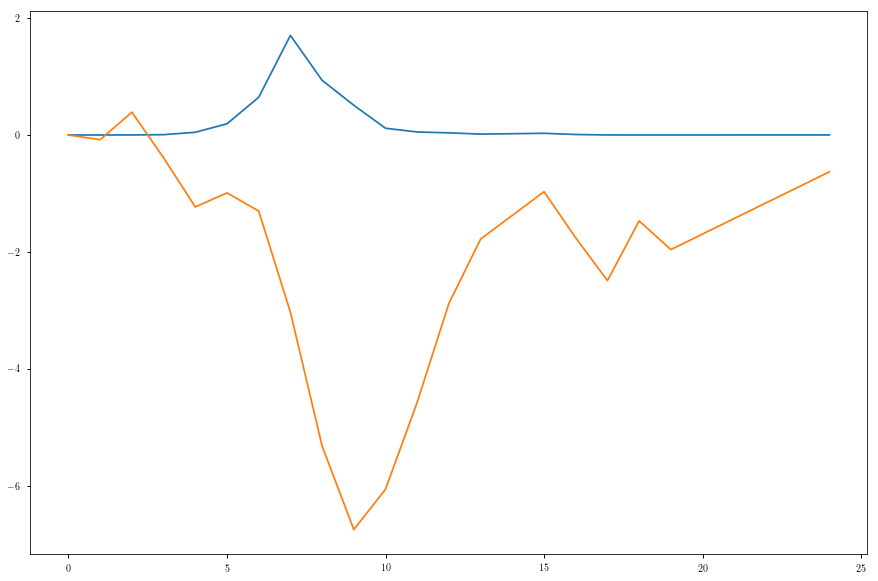

In [102]:
plt.plot(dataset['t'], dataset[['x','z']])

In [118]:
xdiff = np.gradient(dataset['x'], dataset['t'])
zdiff = np.gradient(dataset['z'], dataset['t'])

xorder = sorted(range(len(xdiff)), key=lambda i: np.abs(xdiff)[i], reverse=True)
zorder = sorted(range(len(xdiff)), key=lambda i: np.abs(zdiff)[i], reverse=True)
corder = sorted(range(len(xdiff)), key=lambda i: np.abs(zdiff * xdiff)[i], reverse=True)

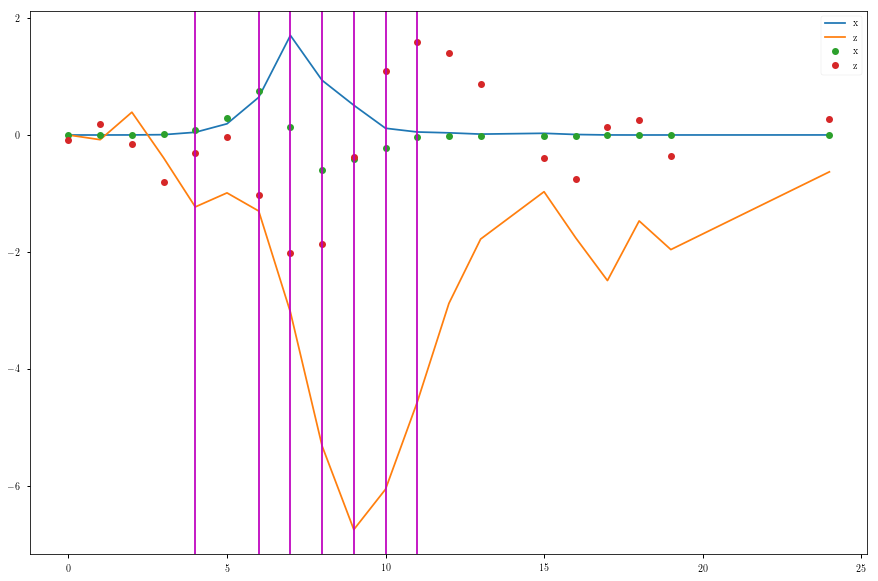

In [124]:
plt.plot(dataset['t'], dataset[['x','z']])
plt.plot(dataset['t'], np.array([xdiff, zdiff]).T, 'o')
plt.legend('xzxz')
[plt.axvline(x=xi, color='m') for xi in dataset['t'].iloc[corder[:7]]]

In [125]:
knot_locs = sorted(dataset['t'].iloc[corder[:7] + [0,-1]])

In [126]:
basis = casbasis.basis_functions(knot_locs, k=3)
xs = lambda t: [b(t) for b in basis]
fine_grid = np.linspace(dataset['t'].iloc[0], dataset['t'].iloc[-1], 100)
all_xs = [xs(t) for t in fine_grid]

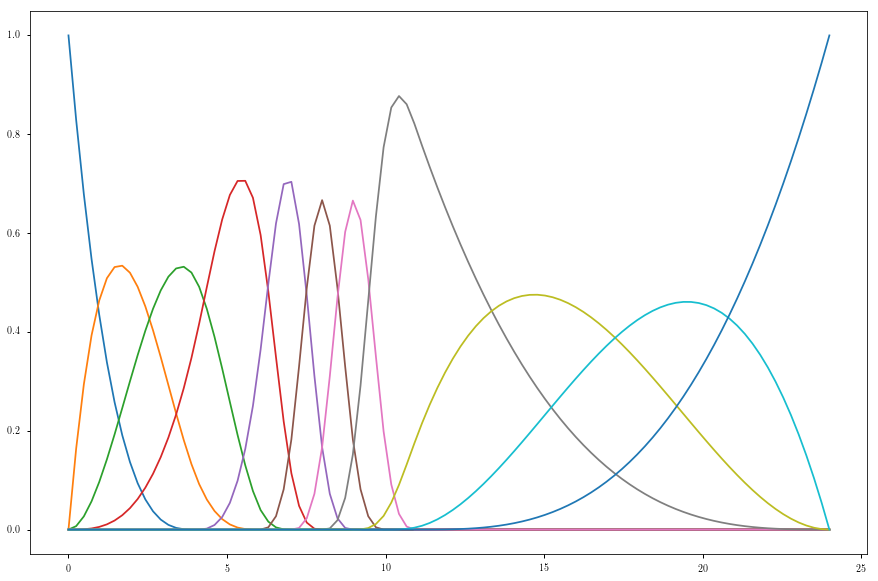

In [127]:
plt.plot(fine_grid, all_xs)

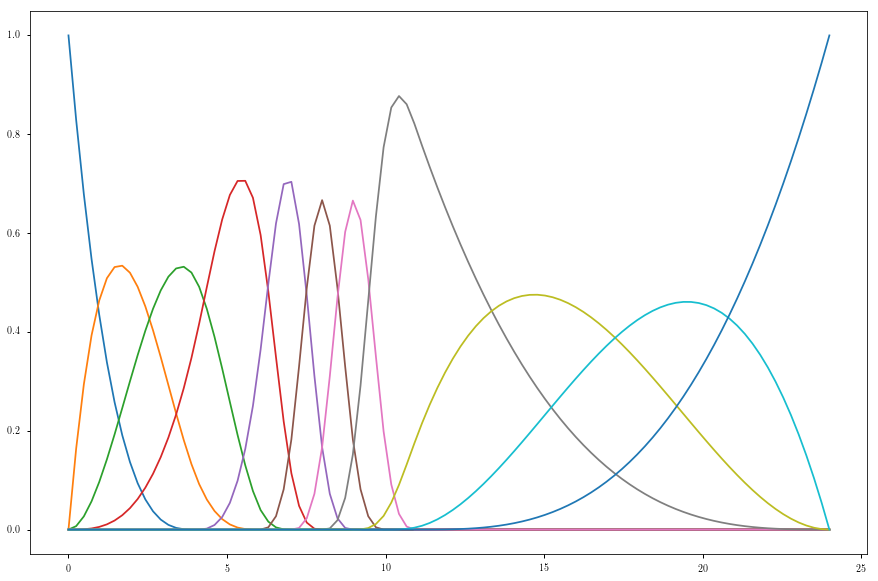

In [128]:
from functions import generic_immune
reload(generic_immune)

knot_locs_auto = generic_immune.knots_from_data(fine_grid, 9, context)

basis_auto = casbasis.basis_functions(knot_locs, k=3)
all_xs_auto = [[b(t) for b in basis] for t in fine_grid]

plt.plot(fine_grid, all_xs_auto)

## Test with actual case

In [129]:
import modeller, fitter
reload(modeller)
reload(fitter)

<module 'fitter' from '/media/dwu402/Data/wrap-mad/fitter.py'>

In [130]:
model = modeller.Model(context)

In [131]:
solver = fitter.Fitter()
solver.construct_objectives(context, model)
solver.construct_problems()

In [174]:
solver.solve(10)

In [133]:
def tokey(rho, ps):
    return f"{'y'.join(map(str,ps))}r{rho}"
getx = fitter.ca.Function("getx", [model.ts, *model.cs], model.xs)

Text(0.5, 0, 'time, t')

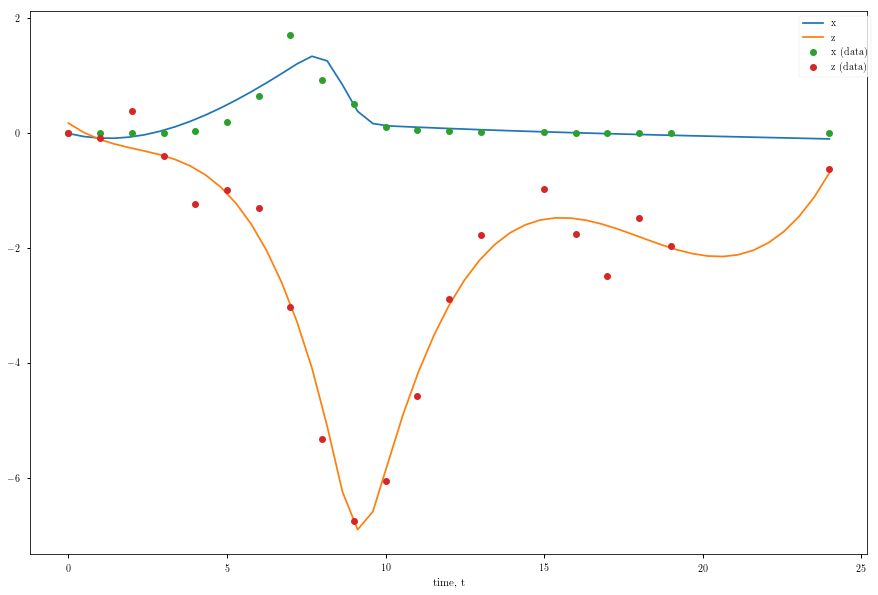

In [175]:
target_rho = 1
c_end = solver.problems[0].cache.results[tokey(target_rho, solver.solutions[str(target_rho)][0].x)].x

xs_end = np.array([np.array(i) for i in getx(model.observation_times, 
                                         *fitter.argsplit(c_end, 
                                                          3)
                                        )])
plt.plot(model.observation_times, np.hstack([xs_end[0], xs_end[2]]),
         context['datasets'][0]['t'], context['datasets'][0]['x'], 'o',
         context['datasets'][0]['t'], context['datasets'][0]['z'], 'o')
plt.legend(list("xz") + ["x (data)", "z (data)"], loc="best", bbox_to_anchor=(1.01, 1))
plt.xlabel("time, t")

Text(0, 0.5, 'z')

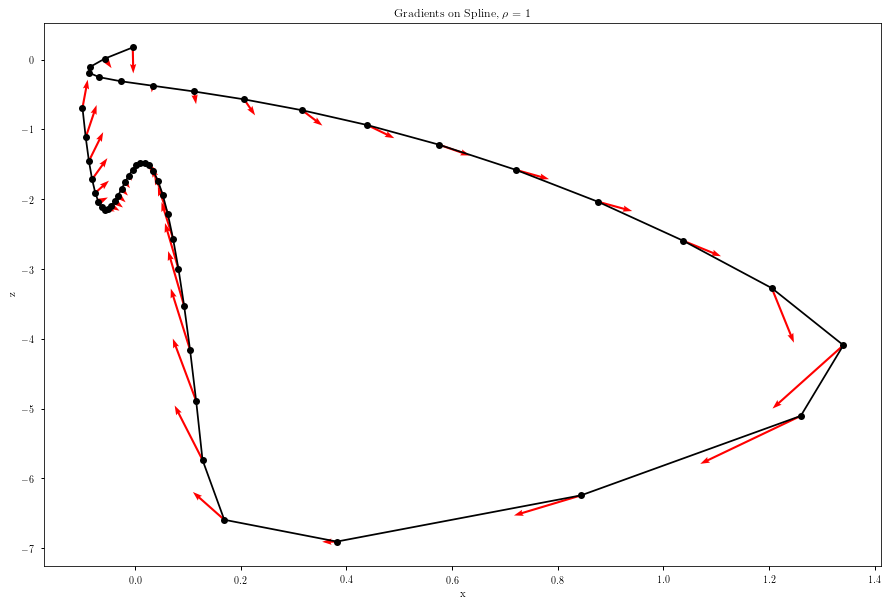

In [176]:
spline_dfield = np.array([context['model'](t, xs_end[:,i], solver.solutions[str(target_rho)][0].x) 
                 for i,t in enumerate(model.observation_times)])

spline_dfield = spline_dfield.reshape(spline_dfield.shape[:2])

plt.quiver(xs_end[0], xs_end[2], spline_dfield[:,0], spline_dfield[:,2], 
           scale=20, angles='xy', headwidth=3, headlength=4.5, headaxislength=4, width=0.0025, color='r')
plt.plot(xs_end[0], xs_end[2], 'ko-')
plt.title(f"Gradients on Spline, $\\rho$ = {target_rho}")
plt.xlabel("x")
plt.ylabel("z")